In [ ]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 8.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tslearn.metrics import dtw, dtw_path
from tslearn.utils import to_time_series_dataset
from IPython.display import HTML
from matplotlib import rc

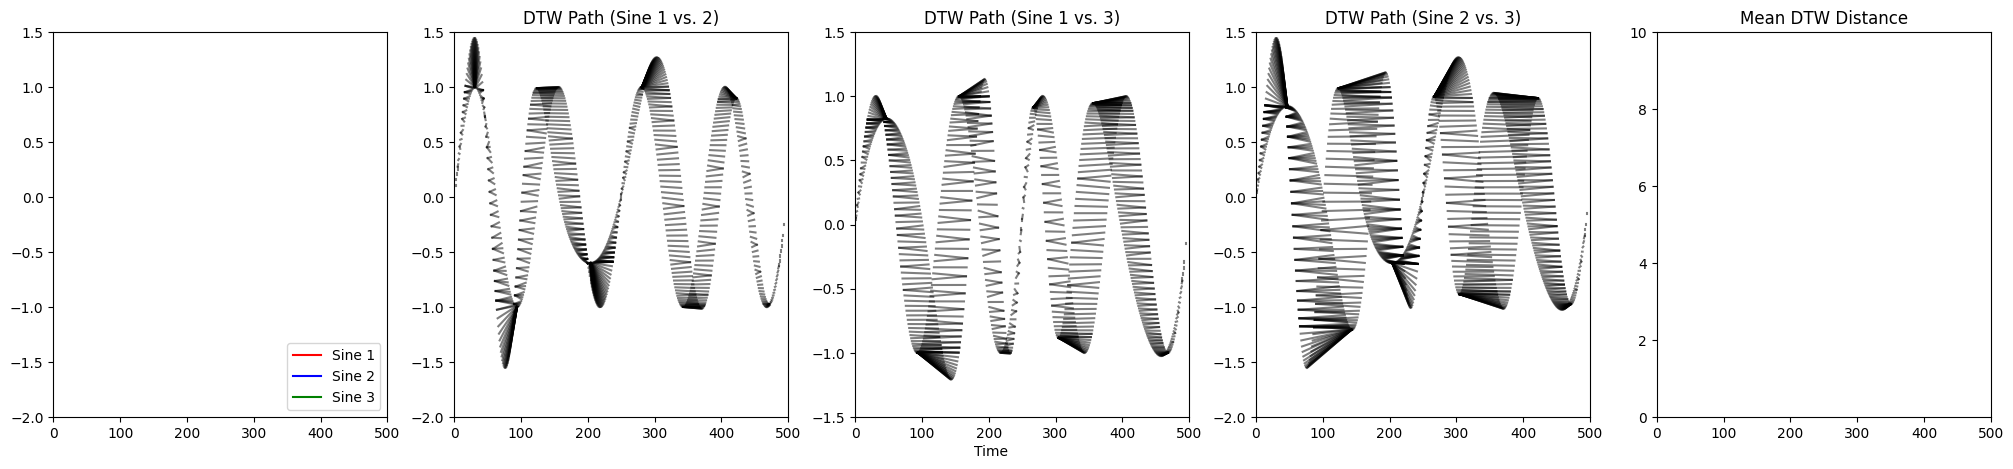

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, HTMLWriter
from tslearn.metrics import dtw_path
from matplotlib import rc
from IPython.display import HTML

# Enable HTML5 rendering for animations
rc('animation', html='html5')

# Define time range and base sine wave
t = np.linspace(0, 8 * np.pi, 500)  # Time over three periods
base_frequency = 1
base_amplitude = 1

# Base sine wave
x = base_amplitude * np.sin(base_frequency * t)

# Create unique amplitude and frequency variations for y2 and y3
amp_variation_y = 0.7 * np.sin(t / 2) * (1 - (t / t[-1]))  # Variation reduces to zero at the end
freq_variation_y = 0.3 * np.sin(t / 4) * (1 - (t / t[-1]))  # Different frequency variation

amp_variation_z = 0.3 * np.cos(t / 2.5) * (1 - (t / t[-1]))  # Different amplitude variation for z
freq_variation_z = 0.5 * np.sin(t / 4) * (1 - (t / t[-1]))  # Different frequency variation for z

# Apply amplitude and frequency variations to create y2 and y3
y = (base_amplitude + amp_variation_y) * np.sin((base_frequency + freq_variation_y) * t)
z = (base_amplitude - amp_variation_z) * np.sin((base_frequency - freq_variation_z) * t)

# Reshape the data for DTW
x_reshaped = x.reshape(-1, 1)
y_reshaped = y.reshape(-1, 1)
z_reshaped = z.reshape(-1, 1)

# Set up figure with five panels (subplots)
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(25, 5))
fig.text(0.5, 0.04, 'Time', ha='center', va='center')

# Initialize the left panel: Time series
line1, = ax1.plot([], [], label="Sine 1", color='r')
line2, = ax1.plot([], [], label="Sine 2", color='b')
line3, = ax1.plot([], [], label="Sine 3", color='g')
ax1.set_xlim(0, len(t))
ax1.set_ylim(-2, 1.5)
ax1.legend(loc = "lower right")

# Initialize the DTW path panels
ax2.set_xlim(0, len(t))
ax2.set_ylim(-2, 1.5)
ax2.set_title("DTW Path (Sine 1 vs. 2)")
path_lines_12 = []  # Store DTW path lines between Curve 1 and Curve 2

ax3.set_xlim(0, len(t))
ax3.set_ylim(-1.5, 1.5)
ax3.set_title("DTW Path (Sine 1 vs. 3)")
path_lines_13 = []  # Store DTW path lines between Curve 1 and Curve 3

ax4.set_xlim(0, len(t))
ax4.set_ylim(-2, 1.5)
ax4.set_title("DTW Path (Sine 2 vs. 3)")
path_lines_23 = []  # Store DTW path lines between Curve 2 and Curve 3

# Initialize the right panel: Mean DTW distance over time
ax5.set_xlim(0, len(t))
ax5.set_ylim(0, 10)
ax5.set_title("Mean DTW Distance")
distance_line, = ax5.plot([], [], color='k')

# To store the mean DTW distances over time for the right panel
mean_dtw_distances = []

# Function to initialize the animation
def init():
    # Initialize all lines with empty data
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    distance_line.set_data([], [])

    return line1, line2, line3, distance_line

# Function to update the animation frame by frame
def update(frame):
    # LEFT PANEL: Show the original time series
    line1.set_data(np.arange(0, frame), x[:frame])
    line2.set_data(np.arange(0, frame), y[:frame])
    line3.set_data(np.arange(0, frame), z[:frame])

    # MIDDLE PANELS: Update the DTW paths
    # Clear previous DTW paths
    for path_line in path_lines_12:
        path_line.remove()
    for path_line in path_lines_13:
        path_line.remove()
    for path_line in path_lines_23:
        path_line.remove()

    path_lines_12.clear()
    path_lines_13.clear()
    path_lines_23.clear()

    # Compute DTW path for the current frame between the curves
    if frame > 1:  # Ensure frame is at least 2 to avoid zero-length input
        # Curve 1 vs. Curve 2
        path12, dist12 = dtw_path(x_reshaped[:frame], y_reshaped[:frame])
        for (i, j) in path12:
            path_line, = ax2.plot([i, j], [x[i], y[j]], 'k-', alpha=0.5)
            path_lines_12.append(path_line)

        # Curve 1 vs. Curve 3
        path13, dist13 = dtw_path(x_reshaped[:frame], z_reshaped[:frame])
        for (i, j) in path13:
            path_line, = ax3.plot([i, j], [x[i], z[j]], 'k-', alpha=0.5)
            path_lines_13.append(path_line)

        # Curve 2 vs. Curve 3
        path23, dist23 = dtw_path(y_reshaped[:frame], z_reshaped[:frame])
        for (i, j) in path23:
            path_line, = ax4.plot([i, j], [y[i], z[j]], 'k-', alpha=0.5)
            path_lines_23.append(path_line)

        # Compute mean DTW distance and update the right panel
        mean_dtw_dist = np.mean([dist12, dist13, dist23])
        mean_dtw_distances.append(mean_dtw_dist)
        distance_line.set_data(np.arange(0, len(mean_dtw_distances)), mean_dtw_distances)

    return line1, line2, line3, distance_line, *path_lines_12, *path_lines_13, *path_lines_23

# Set the maximum number of frames based on the time length
max_frames = len(t)

# Create the animation
anim = FuncAnimation(fig, update, frames=max_frames, init_func=init, blit=False, interval=100)

# Render and display the animation as an HTML5 video
HTML(anim.to_html5_video())